In [140]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import scipy.stats as st

In [141]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [142]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [143]:
#data base path
database_path = "./Resources/hawaii.sqlite"

In [144]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

In [145]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [146]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [155]:
# Save references to each table
Measurement = Base.classes.measurement
Station  = Base.classes.station

In [156]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [157]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [158]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

#Define start and end date of vacation
start_date = '2018-06-01'
end_date = '2018-06-15'

#convert string date to date format
start_dt = (dt.datetime.strptime(start_date,"%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date,"%Y-%m-%d")).date()

#calculate dates one year ago
startdate_oneyearprior = start_dt - dt.timedelta(days=365)
enddate_oneyearprior = end_dt - dt.timedelta(days=365)
temps=calc_temps(startdate_oneyearprior,enddate_oneyearprior)
tmin = temps[0][0]
tavg = round(temps[0][1],2)
tmax=temps[0][2]

#print temps
print(f"Minimum Temp:{tmin} | Average temp:{tavg} | Max Temp: {tmax}")

Minimum Temp:72.0 | Average temp:77.42 | Max Temp: 83.0


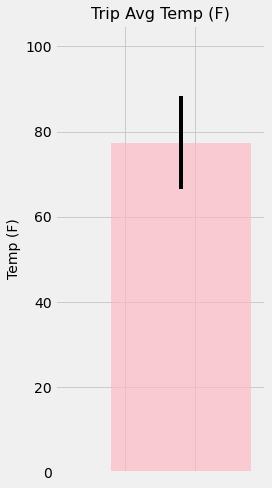

In [159]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror = tmax-tmin

#plot bar chart
plt.figure(figsize = (4,7))
plt.bar(1.5,height=tavg,yerr=yerror, width=2, color='lightpink',alpha=0.65,align="center")
xaxis_values = np.arange(-0.3,3.5,step=1)
plt.title("Trip Avg Temp (F)", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,105)
plt.xticks(xaxis_values,"")
plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [179]:
sel =[Measurement.station, func.sum(Measurement.prcp),
      Station.name,Station.latitude,Station.longitude,Station.elevation]

prcp_station_df = session.query(*sel).\
   filter(Measurement.station == Station.station).\
   filter(Measurement.date>=startdate_oneyearprior).\
   filter(Measurement.date<=enddate_oneyearprior).\
   group_by(Measurement.station).\
   order_by(func.sum(Measurement.prcp).desc()).all()
    

In [180]:
                   
prcp_station_results = pd.DataFrame(prcp_station_df,columns=['date','station','prcp','name','latitude','longitude'])
prcp_station_results.head()

,date,station,prcp,name,latitude,longitude
0,USC00516128,5.51,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.98,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00514830,2.02,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00513117,1.96,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,0.76,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [181]:
# --- check and drop null values from prcp_station_df---
print("Checking for null values...")
#print(f"There are {prcp_station_df['prcp'].isnull().sum()} null values in the precipitation data - dropping!")

prcp_station_results.dropna(axis=0, how="any", inplace=True)

# --- group by station and get total precipitation amount for each station ---
total_prcp = pd.DataFrame(prcp_station_results.groupby('station').sum())

Checking for null values...


### Daily Temperature Normals

In [182]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [183]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'


# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_dt,end_dt)
trip_dates = trip_dates.astype(str)

# Strip off the year and save a list of strings in the format %m-%d
split_year = [x.split("-",1) for x in trip_dates]
date_str = [x[1] for x in split_year]
date_str

# Loop through the list of %m-%d strings and calculate the normals for each date

# --- create an empty list to store normals ---
normals = [daily_normals(n) for n in date_str]

In [184]:
#Extracts tuples into lists
tmin_list =[]
tavg_list = []
tmax_list = []
dn_list = []

# --- for loop to calculate normals for each date in trip_dates list ---
for n in normals: dn_list.append(n[0])
    
for tmin,tavg,tmax in dn_list:
    tmin_list.append(tmin)
    tavg_list.append(tavg)
    tmax_list.append(tmax)
    

In [185]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

dailynormals_df = pd.DataFrame({"TMIN":tmin_list,"TAVG":tavg_list,"TMAX":tmax_list},index=trip_dates) 

dailynormals_df

,TMIN,TAVG,TMAX
2018-06-01,64.0,74.614035,81.0
2018-06-02,65.0,74.400000,81.0
2018-06-03,65.0,74.034483,80.0
2018-06-04,65.0,73.818182,81.0
2018-06-05,68.0,74.854545,81.0
2018-06-06,70.0,75.175439,80.0
2018-06-07,68.0,75.071429,81.0
2018-06-08,70.0,75.586207,81.0
2018-06-09,69.0,75.152542,81.0
2018-06-10,68.0,75.142857,81.0


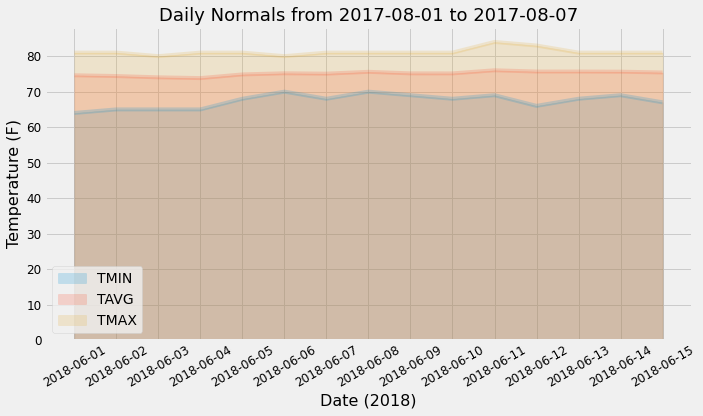

In [186]:
# Plot the daily normals as an area plot with `stacked=False`

dailynormals_df.plot.area(figsize=(10,6), stacked=False, alpha = 0.2, rot=30, fontsize=12)

plt.xticks(np.arange(len(trip_dates)), labels=trip_dates)

plt.title(f"Daily Normals from {start_date} to {end_date}", fontsize=18)
plt.xlabel("Date (2018)", fontsize=16)
plt.ylabel("Temperature (F)", fontsize=16)

plt.tight_layout()
plt.savefig("Images/dailynormals.png")
plt.show()

## Close Session